# Multicriteria Spatial Analysis: Ideal retirement areas in Colombia   
# Part II

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia  
Authors: Alicia Arévalo Robinson and Ricardo Andrés Martinez Soto  
Link to repository:

## Import libraries

In [1]:
import rasterio
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors
import geopandas as gpd

## Load Raster Layers

This section loads all previously prepared raster layers that are aligned to the same extent, resolution and coordinate reference system (CRS). These layers will be used to evaluate suitability based on terrain, proximity, and legal constraints.

The rasters include:

- **DEM**: Digital Elevation Model in metres above sea level.
- **Slope**: Derived from the DEM, expressed in percentage (%).
- **Roads**: Binary raster showing the location of road infrastructure (1 = road, 0 = background).
- **Protected Areas**: Binary raster where protected zones are marked (1 = protected, 0 = non-protected).
-   
-   
-  
-  


These layers will serve as the input for generating both **factors** (e.g. proximity to roads) and **constraints** (e.g. protected areas, high slope) in the spatial multi-criteria evaluation.

## Load data

In [2]:
# Define paths

dem_path = "./data/clip/dem_cundi.tif"
slope_path =  "./data/clip/dem_cundi_slope.tif"

road_raster_path = "./data/raster/road_raster.tif"

aqueduct_raster_path = "./data/raster/aqueduct_raster.tif"
sewers_raster_path = "./data/raster/sewerage_raster.tif"

indigenous_raster_path = "./data/raster/indigenous_raster.tif"

min_raster_path = "./data/raster/min_raster.tif"

muni_raster_path = "./data/raster/muni_raster.tif"

cover_raster_path = "./data/raster/cover_raster.tif"

runap_raster_path = "./data/raster/runap_raster.tif"

temp_raster_path = "./data/raster/temp_raster.tif"

pop_center_raster_path = "./data/raster/popcenter_raster.tif"

### Open raster data

In [3]:
# Load all rasters into memory
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    dem_meta = src.meta
    transform = src.transform
    bounds = src.bounds
    print(" DEM loaded",src.shape,src.crs)

with rasterio.open(slope_path) as src:
    slope = src.read(1)
    print(" Slope raster loaded",src.shape,src.crs)

with rasterio.open(road_raster_path) as src:
    roads = src.read(1)
    print(" Roads raster loaded",src.shape,src.crs)

with rasterio.open(aqueduct_raster_path) as src:
    rivers = src.read(1)
    print(" Aqueduct raster loaded",src.shape,src.crs)

with rasterio.open(sewers_raster_path) as src:
    sewers = src.read(1)
    print(" Sewers raster loaded",src.shape,src.crs)

with rasterio.open(indigenous_raster_path) as src:
    indigenous = src.read(1)    
    print(" Indigenous areas raster loaded",src.shape,src.crs)

with rasterio.open(min_raster_path) as src:
    min_raster = src.read(1)
    print(" Mining raster loaded",src.shape,src.crs)    

with rasterio.open(muni_raster_path) as src:
    muni = src.read(1)
    print(" Municipalities raster loaded",src.shape,src.crs)

with rasterio.open(cover_raster_path) as src:
    cover = src.read(1)
    print(" Land cover raster loaded",src.shape,src.crs)

with rasterio.open(runap_raster_path) as src:
    runap = src.read(1)
    print(" Runap raster loaded",src.shape,src.crs)

with rasterio.open(temp_raster_path) as src:
    temp = src.read(1)
    print(" Temperature raster loaded",src.shape, src.crs)

with rasterio.open(pop_center_raster_path) as src:
    popcenter = src.read(1)
    print(" Populated centers raster loaded",src.shape, src.crs)

 DEM loaded (6094, 5336) ESRI:103599
 Slope raster loaded (6094, 5336) ESRI:103599
 Roads raster loaded (6094, 5336) ESRI:103599
 Aqueduct raster loaded (6094, 5336) ESRI:103599
 Sewers raster loaded (6094, 5336) ESRI:103599
 Indigenous areas raster loaded (6094, 5336) ESRI:103599
 Mining raster loaded (6094, 5336) ESRI:103599
 Municipalities raster loaded (6094, 5336) ESRI:103599
 Land cover raster loaded (6094, 5336) ESRI:103599
 Runap raster loaded (6094, 5336) ESRI:103599
 Temperature raster loaded (6094, 5336) ESRI:103599
 Populated centers raster loaded (6094, 5336) ESRI:103599


## Factors

## Compute Euclidean Distance to Roads, Populated centers 

Euclidean distance rasters calculated in map units.


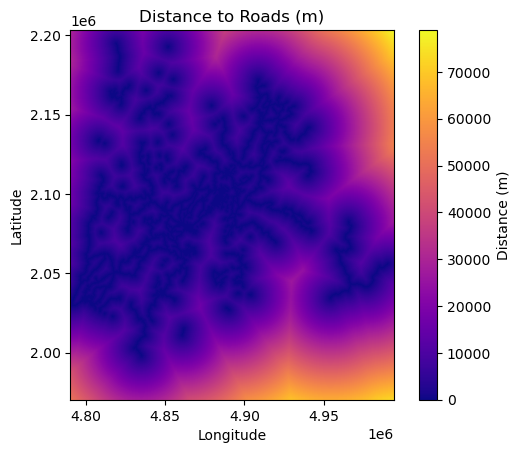

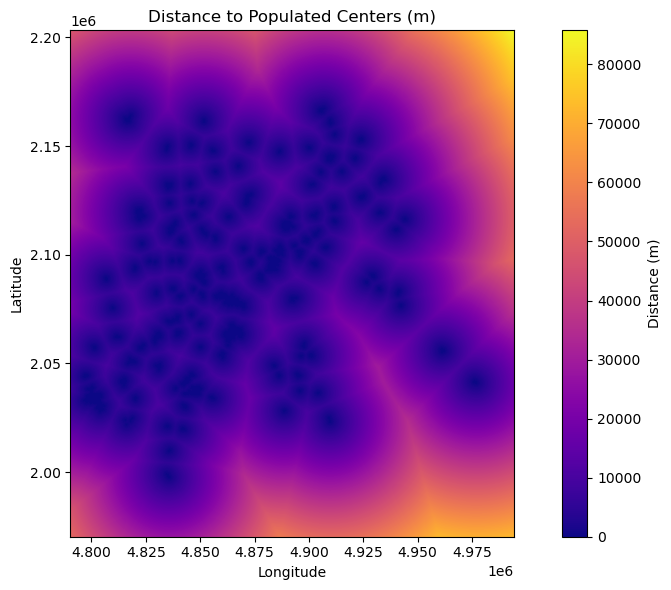

In [4]:
# Invert binary rasters (1 = feature → 0 for distance transform)
# distance_transform_edt computes distance TO the nearest zero
roads_inv = roads == 0
popcenter_inv = popcenter == 0
#  Compute Euclidean distance in pixels
dist_roads_px = distance_transform_edt(roads_inv)
dist_popcenter_px = distance_transform_edt(popcenter_inv)

#  Convert distances to map units using pixel size (assume square pixels)
pixel_size = transform[0]  # pixel width in map units (e.g., metres)
dist_roads_m = dist_roads_px * pixel_size
dist_popcenter_m = dist_popcenter_px * pixel_size

print("Euclidean distance rasters calculated in map units.")

# Optional visualisation


plt.imshow(dist_roads_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

plt.title("Distance to Roads (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Distance (m)")

plt.figure(figsize=(10, 6))
plt.imshow(dist_popcenter_m, cmap='plasma', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.title("Distance to Populated Centers (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Distance (m)")

plt.grid(False)

plt.tight_layout()
plt.show()


### Factor Normalisation for Spatial Multi-Criteria Analysis (SMCA)

In [5]:
# Recompute extent from DEM metadata
xmin, ymax = dem_meta["transform"] * (0, 0)
xmax, ymin = dem_meta["transform"] * (dem_meta["width"], dem_meta["height"])
extent = [xmin, xmax, ymin, ymax]

In [6]:
# Normalise slope (cost factor) to 0–10 

def normalise_slope_cost(slope_array, threshold=20.0):
    """
    Normalise slope as a cost factor: lower slopes are more suitable.
    Suitability = 10 at 0% slope, drops linearly to 0 at threshold (e.g., 20%).
    Values above threshold are clipped to 0.
    """
    slope_clipped = np.clip(slope_array, 0, threshold)
    norm = 10 * (threshold - slope_clipped) / threshold
    return np.clip(norm, 0, 10)

# Apply with 20% slope threshold
slope_norm = normalise_slope_cost(slope, threshold=20.0)
print("✅ Slope normalised (0–10): >20% slope = not suitable (0)")


# Normalise road proximity (benefit factor) to 0–10 

def normalise_proximity(dist_array, threshold=2000.0):
    """
    Normalise a proximity benefit factor to a 0–10 scale.
    0 m = suitability 10; ≥ threshold = 0.
    """
    clipped = np.clip(dist_array, 0, threshold)
    norm = 10 * (1 - (clipped / threshold))
    return np.clip(norm, 0, 10)

road_proximity_norm = normalise_proximity(dist_roads_m, threshold=2000)
print("✅ Road proximity normalised (0–10): closer = better (cut-off: 2000 m)")




✅ Slope normalised (0–10): >20% slope = not suitable (0)
✅ Road proximity normalised (0–10): closer = better (cut-off: 2000 m)


In [ ]:
# Normalise populated center proximity (benefit factor) to 0–10 

def normalise_proximity(dist_array, threshold=2000.0):
    """
    Normalise a proximity benefit factor to a 0–10 scale.
    0 m = suitability 10; ≥ threshold = 0.
    """
    clipped = np.clip(dist_array, 0, threshold)
    norm = 10 * (1 - (clipped / threshold))
    return np.clip(norm, 0, 10)

road_proximity_norm = normalise_proximity(dist_roads_m, threshold=2000)
print("✅ Populated center proximity normalised (0–10): closer = better (cut-off: 2000 m)")